In [1]:
import pickle

In [2]:
from pathlib import Path

In [3]:
import os
current = Path('.').resolve()
if current.name == 'notebooks':
    os.chdir('..')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import alphamoon

In [6]:
import alphamoon.constants

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [36]:
input_data_path = alphamoon.constants.RAW_DATA_DIR / 'train.pkl'
with input_data_path.open('rb') as file_handle:
    X, y = pickle.load(file_handle)

In [37]:
X.shape

(30134, 3136)

In [38]:
y.shape

(30134, 1)

In [39]:
count_arr = np.bincount(y[:,0])

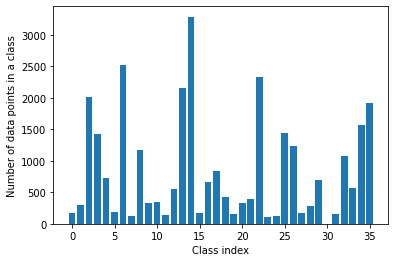

In [13]:
plt.bar(np.arange(len(count_arr)), count_arr)
plt.xlabel('Class index')
plt.ylabel('Number of data points in a class')
plt.savefig(alphamoon.constants.REPORTS_FIGURES_DIR / 'data_points_per_class.png', bbox_inches='tight', dpi=300)
plt.show()

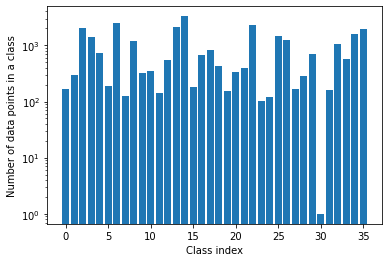

In [22]:
plt.bar(np.arange(len(count_arr)), count_arr)
plt.xlabel('Class index')
plt.ylabel('Number of data points in a class')
plt.yscale('log')
output_file = alphamoon.constants.REPORTS_FIGURES_DIR / 'data_points_per_class_logscale.png'
plt.savefig(output_file, bbox_inches='tight', dpi=300)
plt.show()

Data set is unbalanced

# One-shot learning example

In [21]:
num_classes = len(count_arr)

In [41]:
one_shot_example = np.where(y[:, 0] == 30)[0][0]

In [42]:
img_w_h = int(np.sqrt(X.shape[1]))

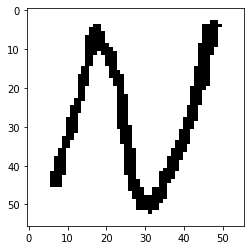

In [43]:
plt.imshow(np.reshape(X[one_shot_example], 
                      (img_w_h, img_w_h)), cmap='binary')
output_file = alphamoon.constants.REPORTS_FIGURES_DIR / 'one_shot_example.png'
plt.savefig(output_file, bbox_inches='tight', dpi=300)
plt.show()

# Idea: Siamese network

## Train and Test sets

There are 30314 examples altogether. Let's take 2:1 train to test.

Problem: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Solution: Data augmentation?

In [79]:
import torch

In [135]:
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image

transform_train = transforms.RandomAffine((4, 4), (0.1, 0.1))

In [77]:
X_prim = X.reshape((X.shape[0], img_w_h, img_w_h, 1))

In [80]:
X_prim_tensor = torch.Tensor(X_prim)

In [164]:
x_train_aug = X_prim_tensor[one_shot_example,...]

In [167]:
x_train_aug = x_train_aug[None]

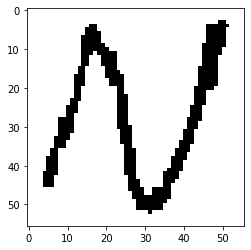

In [259]:
transform_train = transforms.RandomAffine(0, (0.1, 0.1), (0.9, 1.1))
x = transform_train.forward(x_train_aug)
plt.imshow(x[0,...], cmap='binary');

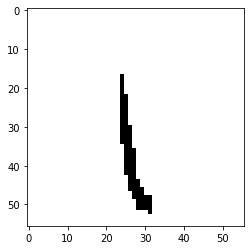

In [261]:
plt.imshow(transforms.RandomRotation(10).forward(x_train_aug)[0, ...], cmap='Greys');

### Something is really weird with these PyTorch transformations, trying regular affine transformations

In [253]:
theta = np.deg2rad(-7)
ry = rx = img_w_h/2


r00 = np.cos(theta)
r01 = -np.sin(theta)
r10 = np.sin(theta)
r11 = np.cos(theta)
r02 = rx - r00*rx - r01*ry
r12 = ry - r10*rx - r11*ry

In [250]:
from scipy.ndimage import affine_transform

In [254]:
rotation = np.array([[r00, r01, r02], [r10, r11, r12], [0, 0, 1]])

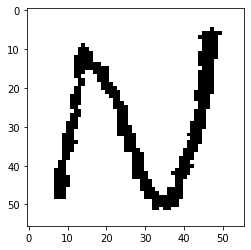

In [256]:
Sx = 0.9
Sy = 1.1
Tx = -5
Ty = 2

affine2 = np.array([[Sy, 0, Tx], [0, Sx, Ty], [0, 0, 1]])
trans = np.matmul(rotation,  affine2)
x2 = affine_transform(X_prim[one_shot_example,..., 0],  trans)
plt.imshow(x2, cmap='binary');

In [257]:
x2_ravel = np.ravel(x2)

In [258]:
x2_ravel

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [262]:
X_augmented = np.vstack((X, x2_ravel))

In [263]:
y_augmented = np.vstack((y, [30]))

```
# Creating Augmented Dataset
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(X_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)


# Shuffle the dataset
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = np.array(X_train_augmented)[shuffle_idx]
y_train_augmented = np.array(y_train_augmented)[shuffle_idx]
```

## Train - Test split

In [264]:
from sklearn.model_selection import StratifiedShuffleSplit

In [265]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=0)

In [268]:
for train_index, test_index in ss.split(X_augmented, y_augmented):
    X_train, X_test = X_augmented[train_index], X_augmented[test_index]
    y_train, y_test = y_augmented[train_index], y_augmented[test_index]

In [269]:
X_train.shape

(20190, 3136)

In [270]:
X_test.shape

(9945, 3136)

## Examples generation

In [300]:
def generate_triplet(X_train, y_train, batch_size):
    import random
    
    img_side_len = X_train.shape[1]
    x_anchors = np.zeros((batch_size, img_side_len))
    x_positives = np.zeros((batch_size, img_side_len))
    x_negatives = np.zeros((batch_size, img_side_len))
    
    for i in range(batch_size):
        idx = random.randint(0, X_train.shape[0] - 1)
        x_anchors[i] = X_train[idx]
        y = y_train[idx, 0]
        
        indices_for_pos = np.where(y_train == y)[0]
        indices_for_neg = np.where(y_train != y)[0]
        
        idx_pos = random.choice(indices_for_pos)
        idx_neg = random.choice(indices_for_neg)
        
        x_positives[i] = X_train[idx_pos]
        x_negatives[i] = X_train[idx_neg]
    return [x_anchors, x_positives, x_negatives]

In [302]:
[anchor, positive, negative] = generate_triplet(X_train, y_train, 1)

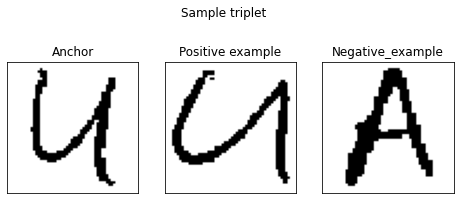

In [318]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(8,4))
ax1.imshow(np.reshape(anchor, (img_w_h, img_w_h)), cmap='binary')
ax2.imshow(np.reshape(positive, (img_w_h, img_w_h)), cmap='binary')
ax3.imshow(np.reshape(negative, (img_w_h, img_w_h)), cmap='binary')
plt.suptitle('Sample triplet')
ax1.set_title('Anchor')
ax2.set_title('Positive example')
ax3.set_title('Negative_example')
tick_params = dict(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax1.tick_params(**tick_params)
ax2.tick_params(**tick_params)
ax3.tick_params(**tick_params)
plt.subplots_adjust(top=1)
output_file = alphamoon.constants.REPORTS_FIGURES_DIR / 'sample_triplet.png'
plt.savefig(output_file, bbox_inches='tight', dpi=300)
plt.show()

A 2D example
```
def generate_examples(X_train, y_train):
    import random 
    
    x_positives = np.zeros(X_train.shape)
    x_negatives = np.zeros(X_train.shape)
    
    for idx in range(X_train.shape[0]):
        y = y_train[idx, 0]
        
        indices_for_pos = np.where(y_train == y)[0]
        indices_for_neg = np.where(y_train != y)[0]
        
        idx_pos = random.choice(indices_for_pos)
        idx_neg = random.choice(indices_for_neg)
        
        x_positives[idx] = X_train[idx_pos]
        x_negatives[idx] = X_train[idx_neg]
    return x_positives, x_negatives
```

## Verification network

[Siamese Neural Networks or One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

![network](model.jpg)

In [293]:
import torch.nn as nn

class KochNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 9) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()
    
    def convs(self, x):
        # out_dim = in_dim - kernel_size + 1  
        #1, 56, 56
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 48, 48
        x = F.max_pool2d(x, (2,2))
        # 64, 24, 24
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn3(self.conv3(x)))
        # 256, 6, 6
        return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))
        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [325]:
class EmbeddingNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
triplet_loss = nn.TripletMarginWithDistanceLoss(
    distance_function=nn.PairwiseDistance(), margin=1)
# output = triplet_loss(anchor, positive, negative)
# output.backward()

In [295]:
# Initialize embeddings
batchsize = 200
embedding = nn.Embedding(batchsize, 128)
anchor_ids = torch.randint(0, batchsize, (1,))
positive_ids = torch.randint(0, batchsize, (1,))
negative_ids = torch.randint(0, batchsize, (1,))
anchor = embedding(anchor_ids)
positive = embedding(positive_ids)
negative = embedding(negative_ids)
# Built-in Distance Function
triplet_loss = \
     nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance())
output = triplet_loss(anchor, positive, negative)
output.backward()

In [299]:
anchor.shape

torch.Size([1, 128])

In [327]:
embedding_model = EmbeddingNet(X_train.shape[1], 64, 64)

In [320]:
n_epochs = 1

In [328]:
margin=1

In [335]:
from torch.utils.data import Dataset

In [ ]:
class TripletDataset(Dataset):
    pass

In [330]:

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super().__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

In [333]:
model = TripletNet(embedding_model)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model.cuda()
loss_fn = nn.TripletMarginWithDistanceLoss(
    distance_function=nn.PairwiseDistance(), margin=margin)
optimizer = torch.optim.Adam(model.parameters())

In [334]:
from alphamoon.models.train_model import train

In [ ]:
loaders = {}
loaders['train'] = None
loaders['valid'] = None

In [ ]:
train(n_epochs, loaders, model, optimizer, loss_fn, use_cuda, 
      alphamoon.constants.MODELS_DIR)